In [1]:
#https://medium.com/towards-formula-1-analysis/formula-1-data-analysis-tutorial-2021-russian-gp-to-box-or-not-to-box-da6399bd4a39

In [1]:
import fastf1 as ff1
from fastf1 import plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.collections import LineCollection
from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.image as image
from skimage.transform import resize
import numpy as np
import pandas as pd

In [2]:
# Setup plotting
#plotting.setup_mpl()
ff1.plotting.setup_mpl(mpl_timedelta_support=True, color_scheme=None, misc_mpl_mods=False)

# Enable the cache
ff1.Cache.enable_cache('cache')

# Get rid of some pandas warnings that are not relevant for us at the moment
pd.options.mode.chained_assignment = None

In [3]:
# Solicitar variables
year = int(input('Año: '))
wknd = int(input('Round: '))
print('------ Session Type ------')
print('R - Race')
print('Q - Qualifying')
print('SQ - Sprint Qualifying')
print('FP1 - Practice 1')
print('FP2 - Practice 2')
print('FP3 - Practice 3')
print('--------------------------')
ses = input('Session :')

Año: 2022
Round: 19
------ Session Type ------
R - Race
Q - Qualifying
SQ - Sprint Qualifying
FP1 - Practice 1
FP2 - Practice 2
FP3 - Practice 3
--------------------------
Session :FP2


In [4]:
# Load the session data
session = ff1.get_session(year, wknd, ses)
session.load()



core           INFO 	Loading data for United States Grand Prix - Practice 2 [v2.2.8]
api            INFO 	No cached data found for driver_info. Loading data...
api            INFO 	Fetching driver list...
api            INFO 	Data has been written to cache!
core        WARNING 	Failed to load data from Ergast API! (This is expected for recent sessions)
api            INFO 	No cached data found for timing_data. Loading data...
api            INFO 	Fetching timing data...
api            INFO 	Parsing timing data...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for timing_app_data. Loading data...
api            INFO 	Fetching timing app data...
api            INFO 	Data has been written to cache!
core           INFO 	Processing timing data...
api            INFO 	No cached data found for session_status_data. Loading data...
api            INFO 	Fetching session status data...
api            INFO 	Data has been written to cache!
api        

In [5]:
laps = session.load_laps(with_telemetry=True)

/opt/anaconda3/lib/python3.9/site-packages/fastf1/core.py:1127: FutureWarning: `Session.load_laps` is deprecated and will beremoved in a future version.
Use `Session.load` instead.
  warnings.warn("`Session.load_laps` is deprecated and will be"
core           INFO 	Loading data for United States Grand Prix - Practice 2 [v2.2.8]
api            INFO 	Using cached data for driver_info
core        WARNING 	Failed to load data from Ergast API! (This is expected for recent sessions)
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
cor

In [6]:
# Calculate RaceLapNumber (LapNumber minus 1 since the warmup lap is included in LapNumber)
laps['RaceLapNumber'] = laps['LapNumber'] - 1

# Starting from lap 45 it started raining
laps = laps.loc[laps['RaceLapNumber'] >= 1]

In [7]:
# Get all drivers
drivers = pd.unique(laps['Driver'])

telemetry = pd.DataFrame()

# Telemetry can only be retrieved driver-by-driver
for driver in drivers:
    driver_laps = laps.pick_driver(driver)
    
    # Since we want to compare distances, we need to collect telemetry lap-by-lap to reset the distance
    for lap in driver_laps.iterlaps():
        driver_telemetry = lap[1].get_telemetry().add_distance()
        driver_telemetry['Driver'] = driver
        driver_telemetry['Lap'] = lap[1]['RaceLapNumber']
        driver_telemetry['Compound'] = lap[1]['Compound']
        
        telemetry = pd.concat([telemetry, driver_telemetry],axis=0)

In [8]:
# Only keep required columns
telemetry = telemetry[['Lap', 'Distance', 'Compound', 'Speed', 'X','Y']]

# Everything that's not intermediate will be "slick"
#telemetry['Compound'].loc[telemetry['Compound'] != 'INTERMEDIATE'] = 'FULL_WET'

In [9]:
telemetry

,Lap,Distance,Compound,Speed,X,Y
2,1,0.000000,UNKNOWN,214,-1346,-379
3,1,2.150000,UNKNOWN,215,-1330,-393
4,1,12.020556,UNKNOWN,218,-1253,-452
5,1,14.281667,UNKNOWN,220,-1236,-466
6,1,24.148333,UNKNOWN,222,-1158,-526
...,...,...,...,...,...,...
852,36,5344.053889,TEST_UNKNOWN,79,-1419,-147
853,36,5348.333056,TEST_UNKNOWN,79,-1388,-172
854,36,5351.953889,TEST_UNKNOWN,79,-1353,-197
855,36,5353.160833,TEST_UNKNOWN,79,-1342,-206


In [10]:
# We want 25 mini-sectors
num_minisectors = 25

# What is the total distance of a lap?
total_distance = max(telemetry['Distance'])

# Generate equally sized mini-sectors 
minisector_length = total_distance / num_minisectors

minisectors = [0]

for i in range(0, (num_minisectors - 1)):
    minisectors.append(minisector_length * (i + 1))

In [11]:
# Assign minisector to every row in the telemetry data
telemetry['Minisector'] =  telemetry['Distance'].apply(
  lambda z: (
    minisectors.index(
      min(minisectors, key=lambda x: abs(x-z)))+1
  )
)

In [12]:
telemetry

,Lap,Distance,Compound,Speed,X,Y,Minisector
2,1,0.000000,UNKNOWN,214,-1346,-379,1
3,1,2.150000,UNKNOWN,215,-1330,-393,1
4,1,12.020556,UNKNOWN,218,-1253,-452,1
5,1,14.281667,UNKNOWN,220,-1236,-466,1
6,1,24.148333,UNKNOWN,222,-1158,-526,1
...,...,...,...,...,...,...,...
852,36,5344.053889,TEST_UNKNOWN,79,-1419,-147,23
853,36,5348.333056,TEST_UNKNOWN,79,-1388,-172,23
854,36,5351.953889,TEST_UNKNOWN,79,-1353,-197,23
855,36,5353.160833,TEST_UNKNOWN,79,-1342,-206,23


In [91]:

# Calculate fastest tyre per mini sector
average_speed = telemetry.groupby(['Lap', 'Minisector', 'Compound'])['Speed'].mean().reset_index()


In [92]:
average_speed

,Lap,Minisector,Compound,Speed
0,1,1,MEDIUM,237.206897
1,1,1,SOFT,240.294118
2,1,1,UNKNOWN,231.068182
3,1,2,MEDIUM,275.521739
4,1,2,SOFT,279.272727
...,...,...,...,...
1960,39,19,TEST_UNKNOWN,112.576271
1961,39,20,TEST_UNKNOWN,189.648649
1962,39,21,TEST_UNKNOWN,245.625000
1963,39,22,TEST_UNKNOWN,194.722222


In [93]:
average_speed.iloc[1100:1150]

,Lap,Minisector,Compound,Speed
1100,14,23,UNKNOWN,134.698068
1101,14,24,TEST_UNKNOWN,191.434783
1102,14,24,UNKNOWN,193.679245
1103,15,1,TEST_UNKNOWN,227.931034
1104,15,1,UNKNOWN,15.199408
1105,15,2,TEST_UNKNOWN,259.924528
1106,15,2,UNKNOWN,221.190385
1107,15,3,TEST_UNKNOWN,235.877193
1108,15,3,UNKNOWN,220.224638
1109,15,4,TEST_UNKNOWN,117.298246


In [94]:
# Select the compound with the highest average speed
fastest_compounds = average_speed.loc[average_speed.groupby(['Lap', 'Minisector'])['Speed'].idxmax()]

# Get rid of the speed column and rename the Compound column
fastest_compounds = fastest_compounds[['Lap', 'Minisector', 'Compound']].rename(columns={'Compound': 'Fastest_compound'})


In [95]:
# Join the fastest compound per minisector with the full telemetry
telemetry = telemetry.merge(fastest_compounds, on=['Lap', 'Minisector'])

# Order the data by distance to make matploblib does not get confused
telemetry = telemetry.sort_values(by=['Distance'])

# Assign integer value to the compound because that's what matplotlib wants
telemetry.loc[telemetry['Fastest_compound'] == "UNKNOWN", 'Fastest_compound_int'] = 1
telemetry.loc[telemetry['Fastest_compound'] == "TEST_UNKNOWN", 'Fastest_compound_int'] = 2


In [96]:
ses = 'FP2'
if ses == 'R': 
    letrero = 'Race'
elif ses == 'Q':
    letrero = 'Qualy'
elif ses == 'SQ':
    letrero = 'Sprint'
else:
    letrero = 'Practice'

In [97]:
def generate_minisector_plot(lap, save=False, details=True):
    
    with cbook.get_sample_data('/Users/rubenrodriguez/Documents/anaconda/fastf1/images/logog.png') as file:
        im = image.imread(file)
    
    fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(15, 8))
    
    plt.rcParams['figure.figsize'] = [15, 8]

    plt.suptitle(f"{session.event['EventName']} {session.event.year} {letrero}\n Mini Sectors Speed - Lap {lap}\n"
             , size=24, y=0.97)


    
    #Modo oscuro
    plt.style.use('dark_background')

    single_lap = telemetry.loc[telemetry['Lap'] == lap]

    x = np.array(single_lap['X'].values)
    y = np.array(single_lap['Y'].values)

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    compound = single_lap['Fastest_compound_int'].to_numpy().astype(float)

    cmap = cm.get_cmap('Spectral', 4)
    lc_comp = LineCollection(segments, norm=plt.Normalize(1, cmap.N+1), cmap=cmap)
    lc_comp.set_array(compound)
    lc_comp.set_linewidth(2)

    plt.rcParams['figure.figsize'] = [12, 5]
    
    if details:
        title = plt.suptitle(
            f"2021 Russian GP \n Lap {lap} - Slicks vs. Inters"
        )
        
    plt.gca().add_collection(lc_comp)
    plt.axis('equal')
    plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
    
    if details:
        cbar = plt.colorbar(mappable=lc_comp, boundaries=np.arange(1, 4))
        cbar.set_ticks(np.arange(1.5, 9.5))
        cbar.set_ticklabels(['Inters', 'Slicks'])
    
    if save:
        plt.savefig(f"minisectors_lap_{lap}.png", dpi=300)
        
    fig.figimage(im, xo=350, yo=210, zorder=13, alpha=.35)


    plt.show()

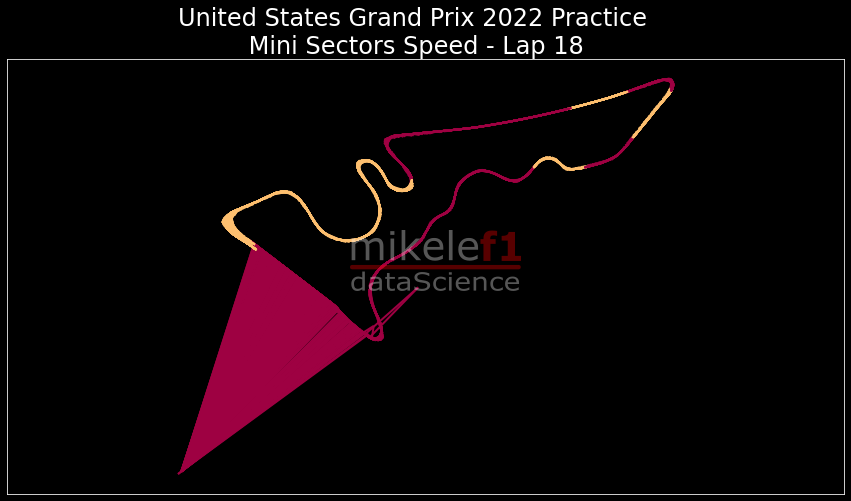

In [103]:
generate_minisector_plot(18, save=False, details=False)
